In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/cifar10/fisher

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 243, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 243 (delta 3), reused 16 (delta 3), pack-reused 206 (from 1)
Receiving objects: 100% (243/243), 226.90 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Updating files: 100% (64/64), done.
/kaggle/working/machine_unlearning_experiments/experiments/cifar10/fisher


## Dependecies

In [2]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

## Utils 

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.resnet50 import load_model_resnet50, init_model_resnet50

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import compute_fisher_matrix, fisher_unlearning, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [5]:
BATCH_SIZE = 32
MINI_BATCH_SIZE = BATCH_SIZE

SIGMA = 1.0

# CALL FISHER

### Files

In [6]:
model_file = project_root / 'experiments/cifar10/naive/ResNet50_CIFAR10_model.pth'
samples_to_unlearn_file = project_root / 'experiments/cifar10/naive/cifar10_samples_to_unlearn.json'
remaining_dataset_file = project_root / 'experiments/cifar10/naive/updated_cifar10_data_splits.json'

### Init models

In [7]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_resnet50(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 233MB/s]


Done initializing model.
Model ID: 135422922980992, Optimizer ID: 135422844747488, Criterion ID: 135422844747584
Done loading model.


## Init data

In [8]:
train_dataset = datasets.CIFAR10(root=data_root, train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root=data_root, train=False, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29709549.54it/s]


Extracting /kaggle/working/machine_unlearning_experiments/data/cifar-10-python.tar.gz to /kaggle/working/machine_unlearning_experiments/data
Files already downloaded and verified


In [9]:
train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=remaining_dataset_file,
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE)

unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


### FIM

In [10]:
fim = compute_fisher_matrix(model_to_unlearn, train_loader, criterion)

Calculating FIM...: 100%|██████████| 1126/1126 [03:16<00:00,  5.72it/s]


### Unlearn

In [11]:
unlearned_model = fisher_unlearning(model_to_unlearn, unlearn_loader, fim, criterion, sigma=SIGMA)

Unlearning Process...: 100%|██████████| 157/157 [00:35<00:00,  4.40it/s]


In [12]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

### Test and metrics

In [13]:
model, *_ = init_model_resnet50()
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 135422845567088, Optimizer ID: 135422845575440, Criterion ID: 135422845567040
Loading and testing model: fisher_ResNet50_CIFAR10


Evaluating model: fisher_ResNet50_CIFAR10_model.pth: 100%|██████████| 313/313 [00:29<00:00, 10.57it/s]

Predictions and labels saved to fisher_ResNet50_CIFAR10_predictions.json


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for fisher_ResNet50_CIFAR10:
  - Test Accuracy: 0.1000
  - Precision: 0.0100
  - Recall: 0.1000
  - F1 Score: 0.0182


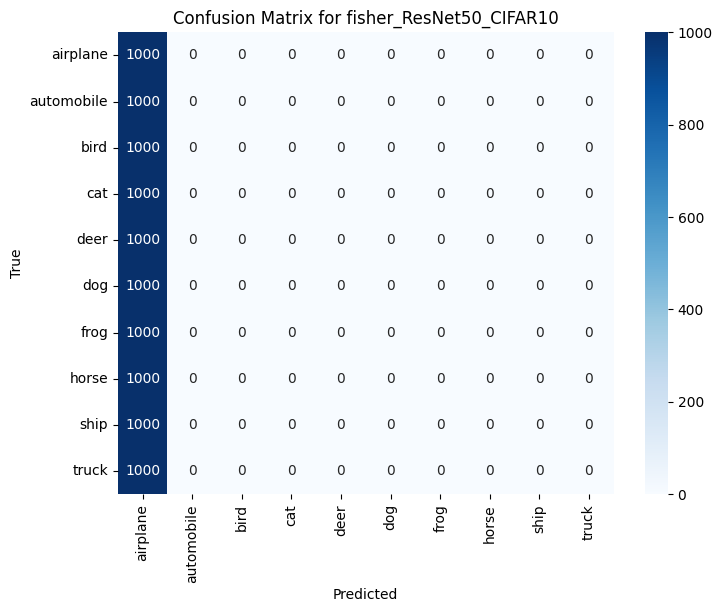

In [16]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
#classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
show_metrics(predictions_path, classes, model_to_unlearn_name)